# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

In [9]:
url1 = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'
import pandas
pd = pandas
df1 = pd.read_csv(url1)

In [17]:
df1

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2/13/11,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [15]:
df1.columns

Index(['Unnamed: 0', 'Customer', 'State', 'Customer Lifetime Value',
       'Response', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size',
       'Vehicle Type'],
      dtype='object')

In [37]:
df_filtered_yes = df1[df1['Response'] == 'Yes']

In [35]:
df_filtered_yes

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
8,8,FM55990,California,5989.773931,Yes,Premium,College,1/19/11,Employed,M,...,0.0,1,Personal Auto,Personal L1,Offer2,Branch,739.200000,Sports Car,Medsize,NaN
15,15,CW49887,California,4626.801093,Yes,Basic,Master,1/16/11,Employed,F,...,0.0,1,Special Auto,Special L1,Offer2,Branch,547.200000,SUV,Medsize,NaN
19,19,NJ54277,California,3746.751625,Yes,Extended,College,2/26/11,Employed,F,...,1.0,1,Personal Auto,Personal L2,Offer2,Call Center,19.575683,Two-Door Car,Large,A
27,27,MQ68407,Oregon,4376.363592,Yes,Premium,Bachelor,2/28/11,Employed,F,...,0.0,1,Personal Auto,Personal L3,Offer2,Agent,60.036683,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10844,10844,FM31768,Arizona,5979.724161,Yes,Extended,High School or Below,2/7/11,Employed,F,...,0.0,3,Personal Auto,Personal L1,Offer2,Agent,547.200000,Four-Door Car,Medsize,NaN
10852,10852,KZ80424,Washington,8382.478392,Yes,Basic,Bachelor,1/27/11,Employed,M,...,0.0,2,Personal Auto,Personal L2,Offer2,Call Center,791.878042,NaN,NaN,A
10872,10872,XT67997,California,5979.724161,Yes,Extended,High School or Below,2/7/11,Employed,F,...,0.0,3,Personal Auto,Personal L3,Offer2,Agent,547.200000,Four-Door Car,Medsize,NaN
10887,10887,BY78730,Oregon,8879.790017,Yes,Basic,High School or Below,2/3/11,Employed,F,...,0.0,7,Special Auto,Special L2,Offer1,Agent,528.200860,SUV,Small,A


In [59]:
df_filtered_yes.object

AttributeError: 'DataFrame' object has no attribute 'object'

In [81]:
def check_claim_amount(claim_amount):
    if claim_amount > 1000.00:
        client_group = 'over 1000'
    else:
        client_group = '1000 or less'
    return client_group

In [83]:
df_filtered_yes['client_group'] = df_filtered_yes['Total Claim Amount'].apply(check_claim_amount)

/var/folders/m0/_0k_jj7j231cxr746m3qlspm0000gn/T/ipykernel_21082/3515243904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_yes['client_group'] = df_filtered_yes['Total Claim Amount'].apply(check_claim_amount)


In [121]:
df_filtered_yes.head()

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type,client_group
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A,1000 or less
8,8,FM55990,California,5989.773931,Yes,Premium,College,1/19/11,Employed,M,...,1,Personal Auto,Personal L1,Offer2,Branch,739.200000,Sports Car,Medsize,NaN,1000 or less
15,15,CW49887,California,4626.801093,Yes,Basic,Master,1/16/11,Employed,F,...,1,Special Auto,Special L1,Offer2,Branch,547.200000,SUV,Medsize,NaN,1000 or less
19,19,NJ54277,California,3746.751625,Yes,Extended,College,2/26/11,Employed,F,...,1,Personal Auto,Personal L2,Offer2,Call Center,19.575683,Two-Door Car,Large,A,1000 or less
27,27,MQ68407,Oregon,4376.363592,Yes,Premium,Bachelor,2/28/11,Employed,F,...,1,Personal Auto,Personal L3,Offer2,Agent,60.036683,Four-Door Car,Medsize,NaN,1000 or less


In [125]:
df_filtered_yes['client_group'].unique()

array(['1000 or less', 'over 1000'], dtype=object)

In [133]:
df_filtered_final = df_filtered_yes2[df_filtered_yes2['client_group'] == 'over 1000']

In [135]:
df_filtered_final

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type,client_group
189,189,OK31456,California,11009.130490,Yes,Premium,Bachelor,1/24/11,Employed,F,...,1,Corporate Auto,Corporate L3,Offer2,Agent,1358.400000,Luxury Car,Medsize,NaN,over 1000
236,236,YJ16163,Oregon,11009.130490,Yes,Premium,Bachelor,1/24/11,Employed,F,...,1,Special Auto,Special L3,Offer2,Agent,1358.400000,Luxury Car,Medsize,A,over 1000
419,419,GW43195,Oregon,25807.063000,Yes,Extended,College,2/13/11,Employed,F,...,2,Personal Auto,Personal L2,Offer1,Branch,1027.200000,Luxury Car,Small,A,over 1000
442,442,IP94270,Arizona,13736.132500,Yes,Premium,Master,2/13/11,Disabled,F,...,8,Personal Auto,Personal L2,Offer1,Web,1261.319869,SUV,Medsize,A,over 1000
587,587,FJ28407,California,5619.689084,Yes,Premium,High School or Below,1/26/11,Unemployed,M,...,1,Personal Auto,Personal L1,Offer2,Web,1027.000029,SUV,Medsize,A,over 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10351,10351,FN44127,Oregon,3508.569533,Yes,Extended,College,1/5/11,Medical Leave,M,...,1,Personal Auto,Personal L2,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN,over 1000
10373,10373,XZ64172,Oregon,10963.957230,Yes,Premium,High School or Below,2/8/11,Employed,M,...,1,Corporate Auto,Corporate L2,Offer1,Agent,1324.800000,Luxury SUV,Medsize,NaN,over 1000
10487,10487,IX60941,Oregon,3508.569533,Yes,Extended,College,1/5/11,Medical Leave,M,...,1,Personal Auto,Personal L3,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN,over 1000
10565,10565,QO62792,Oregon,7840.165778,Yes,Extended,College,1/14/11,Employed,M,...,1,Personal Auto,Personal L3,Offer2,Agent,1008.000000,NaN,NaN,NaN,over 1000


In [191]:
#2 : Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender 
#for customers who have responded "Yes" to the last marketing campaign. Write your conclusions

average_claims = df1.groupby(['Policy Type','Gender','Response'])[['Total Claim Amount']].mean()
display(average_claims)

Total Claim Amount
Policy Type    Gender Response                    
Corporate Auto F      No                388.104574
                      Yes               433.738499
               M      No                472.461272
                      Yes               408.582459
Personal Auto  F      No                407.499560
                      Yes               452.965929
               M      No                462.554331
                      Yes               457.010178
Special Auto   F      No                458.313057
                      Yes               453.280164
               M      No                425.032393
                      Yes               429.527942

In [221]:
average_claims_sorted = average_claims.sort_values(by='Total Claim Amount', ascending = False)
df4 = average_claims_sorted

In [213]:
average_claims_sorted_yes = average_claims[average_claims['Response'] == 'Yes']

KeyError: 'Response'

In [ ]:
#highest average is for men with Personal auto policy type followed closely by women with special auto and personal auto

<Axes: xlabel='Policy Type', ylabel='Count'>

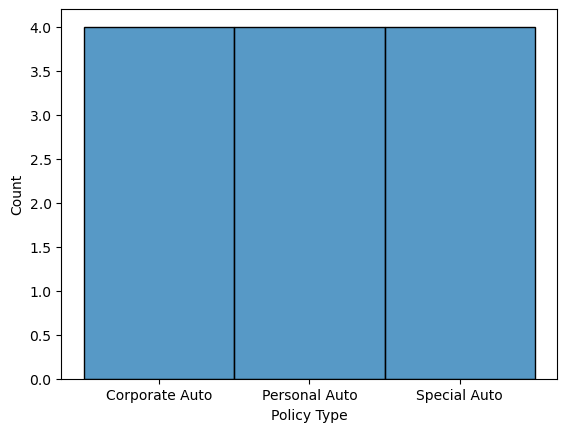

In [231]:
import seaborn as sns

sns.histplot(x='Policy Type', data=df4)

In [234]:
plt.xlabel('Policy Type')
plt.ylabel('Total Claim Amount')
plt.legend(title='Gender')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
3#Analyze the total number of customers who have policies in each state, 
#and then filter the results to only include states where there are more than 500 customers.

In [237]:
df1.nunique()

Unnamed: 0                       10910
Customer                          9134
State                                5
Customer Lifetime Value           8041
Response                             2
Coverage                             3
Education                            5
Effective To Date                   59
EmploymentStatus                     5
Gender                               2
Income                            5694
Location Code                        3
Marital Status                       3
Monthly Premium Auto               202
Months Since Last Claim             36
Months Since Policy Inception      100
Number of Open Complaints            6
Number of Policies                   9
Policy Type                          3
Policy                               9
Renew Offer Type                     4
Sales Channel                        4
Total Claim Amount                5106
Vehicle Class                        6
Vehicle Size                         3
Vehicle Type             

In [241]:
df1['Policy'].unique()

array(['Corporate L3', 'Personal L3', 'Personal L2', 'Corporate L2',
       'Personal L1', 'Special L1', 'Corporate L1', 'Special L3',
       'Special L2'], dtype=object)

In [255]:
state_df = df1.groupby(['State','Policy'])[['Customer']].count()
display(state_df)

Customer
State      Policy                
Arizona    Corporate L1        62
           Corporate L2       119
           Corporate L3       200
           Personal L1        293
           Personal L2        434
           Personal L3        742
           Special L1          25
           Special L2          35
           Special L3          27
California Corporate L1       164
           Corporate L2       246
           Corporate L3       425
           Personal L1        439
           Personal L2        905
           Personal L3       1250
           Special L1          18
           Special L2          49
           Special L3          56
Nevada     Corporate L1        37
           Corporate L2        73
           Corporate L3       109
           Personal L1        136
           Personal L2        212
           Personal L3        391
           Special L1           5
           Special L2          18
           Special L3          12
Oregon     Corporate L1        94
           Corporate L2       174
           Corporate L3       324
           Personal L1        405
           Personal L2        618
           Personal L3       1157
           Special L1          21
           Special L2          63
           Special L3          53
Washington Corporate L1        40
           Corporate L2        46
           Corporate L3        89
           Personal L1        125
           Personal L2        230
           Personal L3        327
           Special L1           5
           Special L2          14
           Special L3          12

In [261]:
def sorting_state_function(nb_customer):
    if nb_customer > 500:
        state_group = 'over 500'
    else:
        state_group = 'under 500'
    return(sorting_state_function)

In [273]:
state_df_check = state_df.apply(sorting_state_function)



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
#4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

In [287]:
df_max = df1.groupby(['Education','Gender'])[['Customer Lifetime Value']].max()
#max value are for female with Bachelor education, doctor level seem to have the least customer lifetime value

Customer Lifetime Value
Education            Gender                         
Bachelor             F                   73225.95652
                     M                   67907.27050
College              F                   61850.18803
                     M                   61134.68307
Doctor               F                   44856.11397
                     M                   32677.34284
High School or Below F                   55277.44589
                     M                   83325.38119
Master               F                   51016.06704
                     M                   50568.25912

In [289]:
df_min = df1.groupby(['Education','Gender'])[['Customer Lifetime Value']].min()
#suprisingly min are quite close regardless of education level

Customer Lifetime Value
Education            Gender                         
Bachelor             F                   1904.000852
                     M                   1898.007675
College              F                   1898.683686
                     M                   1918.119700
Doctor               F                   2395.570000
                     M                   2267.604038
High School or Below F                   2144.921535
                     M                   1940.981221
Master               F                   2417.777032
                     M                   2272.307310

In [291]:
df1_median = df1.groupby(['Education','Gender'])[['Customer Lifetime Value']].median()
#median is quite close which confirms the high gaps between min and max value of customer lifetime value within each education level

Customer Lifetime Value
Education            Gender                         
Bachelor             F                   5640.505303
                     M                   5548.031892
College              F                   5623.611187
                     M                   6005.847375
Doctor               F                   5332.462694
                     M                   5577.669457
High School or Below F                   6039.553187
                     M                   6286.731006
Master               F                   5729.855012
                     M                   5579.099207

## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

In [355]:
#5 The marketing team wants to analyze the number of policies sold by state and month. 
#Present the data in a table where the months are arranged as columns and the states are arranged as rows.
df1_cleanedstate = df1.dropna(subset=['State'])
df1_cleanedstate['Count sales'] = 1

df1_cleanedstate['Effective To Date'] = pd.to_datetime(df1['Effective To Date'], errors='coerce')

df1_cleanedstate['Effective Month'] = df1['Effective To Date'].dt.month


df1_cleanedstate.head()

/var/folders/m0/_0k_jj7j231cxr746m3qlspm0000gn/T/ipykernel_21082/469986919.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleanedstate['Count sales'] = 1
/var/folders/m0/_0k_jj7j231cxr746m3qlspm0000gn/T/ipykernel_21082/469986919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleanedstate['Effective To Date'] = pd.to_datetime(df1['Effective To Date'], errors='coerce')
/var/folders/m0/_0k_jj7j231cxr746m3qlspm0000gn/T/ipykernel_21082/469986919.py:8: SettingWithCopyWarning: 
A value is trying 

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type,Effective Month,Count sales
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2011-02-18,Employed,M,...,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN,2,1
1,1,KX64629,California,2228.525238,No,Basic,College,2011-01-18,Unemployed,F,...,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN,1,1
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2011-02-10,Employed,M,...,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A,2,1
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,2011-01-11,Employed,M,...,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A,1,1
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,2011-01-17,Medical Leave,F,...,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN,1,1


In [341]:
df1_cleanedstate['State'].unique()

array(['Arizona', 'California', 'Washington', 'Oregon', 'Nevada'],
      dtype=object)

In [377]:
desired_columns = ['State', 'Effective Month', 'Count sales']
df2 = df1_cleanedstate[desired_columns]

In [387]:
pivot_df = df2.pivot_table(index='State', columns='Effective Month', values=['Count sales'], aggfunc='sum')

In [401]:
df2.pivot(index='State', columns='Effective Month', values='Count sales').columns

ValueError: Index contains duplicate entries, cannot reshape

In [405]:
df2_multiindex = df2.set_index(['State', 'Effective Month'])
df2_multiindex
stacked_data = df2_multiindex.stack()
stacked_data

State       Effective Month             
Arizona     2                Count sales    1
California  1                Count sales    1
Washington  2                Count sales    1
Oregon      1                Count sales    1
                             Count sales    1
                                           ..
Nevada      2                Count sales    1
            1                Count sales    1
Oregon      1                Count sales    1
Arizona     2                Count sales    1
California  2                Count sales    1
Length: 10279, dtype: int64

In [403]:
unstacked_data = stacked_data.unstack('Effective Month')

ValueError: Index contains duplicate entries, cannot reshape

In [413]:
#6 Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.
#Hint:

#To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. 
#Afterwards, you will need to sort the data by the count of policies sold in descending order.
#Next, you will select the top 3 states with the highest number of policies sold.
#Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.

df1_cleanedstate

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type,Effective Month,Count sales
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2011-02-18,Employed,M,...,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN,2,1
1,1,KX64629,California,2228.525238,No,Basic,College,2011-01-18,Unemployed,F,...,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN,1,1
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2011-02-10,Employed,M,...,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A,2,1
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,2011-01-11,Employed,M,...,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A,1,1
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,2011-01-17,Medical Leave,F,...,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,10904,QI63521,Nevada,19228.463620,No,Basic,High School or Below,2011-02-24,Unemployed,M,...,Personal Auto,Personal L2,Offer1,Branch,897.600000,Luxury SUV,Medsize,A,2,1
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,2011-01-19,Unemployed,F,...,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A,1,1
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,2011-01-06,Employed,F,...,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A,1,1
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2011-02-06,Employed,F,...,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN,2,1


In [429]:
df1_cleanedstate.groupby(['State','Effective Month'])[['Count sales']].count()

AttributeError: 'Series' object has no attribute 'columns'

In [435]:
#7 

melted_data = pd.melt(df1_cleanedstate, id_vars=['State', 'Response'], value_vars=['Count sales'], var_name='Indicator', value_name='Value') #value_vars and value_name to change how it's displayed
melted_data

AttributeError: 'Series' object has no attribute 'columns'